In [4]:
import os
import shutil
import librosa
import numpy as np
import soundfile as sf
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import Audio, display

# 1. Separate non-silent segments

Audio loaded: C:\Users\ziyif\OneDrive\文档\GitHub\ML-Acoustic-DPI-Adherence\0. Data\1. Full_length_samples\sample_3.wav, Duration: 13.53s, Sample rate: 8000
Detected 4 non-silent segments.
Saved: Segment_example\labeled_segments_3\0_click_3.wav
Saved: Segment_example\labeled_segments_3\1_exhale_before_3.wav
Saved: Segment_example\labeled_segments_3\2_inhale_3.wav
Saved: Segment_example\labeled_segments_3\3_exhale_after_3.wav


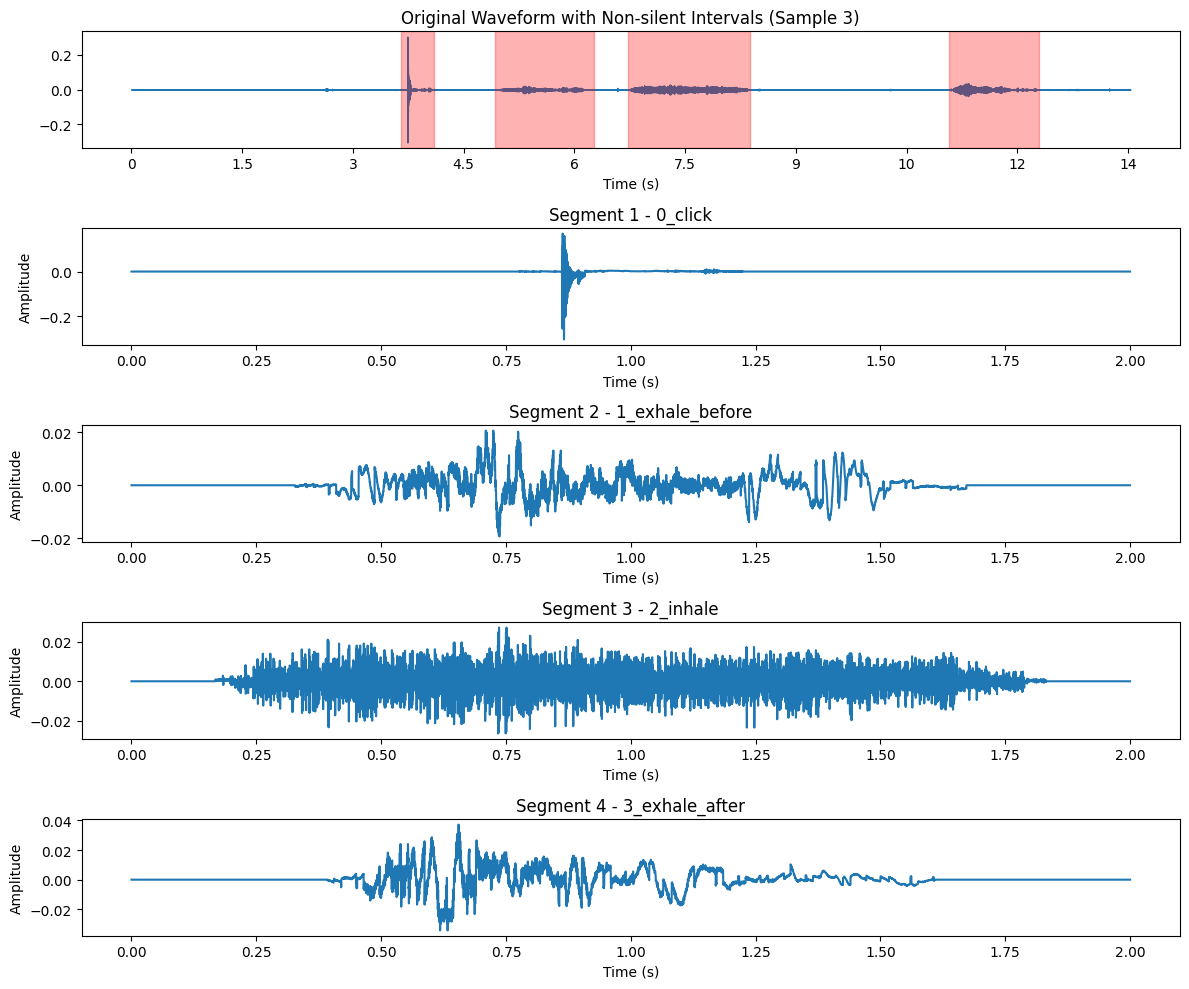


🔊 Audio Playback:
▶️ Segment 1: 0_click


▶️ Segment 2: 1_exhale_before


▶️ Segment 3: 2_inhale


▶️ Segment 4: 3_exhale_after


In [11]:
# Visualization of an example
# ========================== Configuration Parameters ==========================
sample_number = 3
input_wav = fr"..\0. Data\1. Full_length_samples\sample_{sample_number}.wav"  
output_dir = f"Segment_example\labeled_segments_{sample_number}"                                
top_db = 25                      # Silence removal threshold (in dB)
target_duration_sec = 2.0        # Target duration for each segment (in seconds)
activity_labels = ['0_click', '1_exhale_before', '2_inhale', '3_exhale_after']

# ========================== Load Audio ==========================
y, sr = librosa.load(input_wav, sr=None)
print(f"Audio loaded: {input_wav}, Duration: {len(y)/sr:.2f}s, Sample rate: {sr}")

# ========================== Detect Non-silent Segments ==========================
non_silent_intervals = librosa.effects.split(y, top_db=top_db)
print(f"Detected {len(non_silent_intervals)} non-silent segments.")

# ========================== Create Output Directory ==========================
os.makedirs(output_dir, exist_ok=True)

# ========================== Process and Save Segments ==========================
target_length = int(sr * target_duration_sec)
segments = []

for idx, (start, end) in enumerate(non_silent_intervals):
    if idx >= len(activity_labels):
        print("Warning: more segments detected than expected activities.")
        break

    segment = y[start:end]
    seg_len = len(segment)

    # Center crop or zero-padding
    if seg_len > target_length:
        center = seg_len // 2
        segment = segment[center - target_length // 2 : center + target_length // 2]
    elif seg_len < target_length:
        pad_width = (target_length - seg_len) // 2
        segment = np.pad(segment, (pad_width, target_length - seg_len - pad_width))

    segments.append(segment)

    # Save as individual WAV files
    label = activity_labels[idx]
    output_path = os.path.join(output_dir, f"{label}_{sample_number}.wav")
    sf.write(output_path, segment, sr)
    print(f"Saved: {output_path}")

# ========================== Waveform Visualization (Original + Segments) ==========================
plt.figure(figsize=(12, 2 + 2 * len(segments)))

# Original waveform
plt.subplot(len(segments) + 1, 1, 1)
librosa.display.waveshow(y, sr=sr)
plt.title(f"Original Waveform with Non-silent Intervals (Sample {sample_number})")
for start, end in non_silent_intervals:
    plt.axvspan(start/sr, end/sr, color='red', alpha=0.3)
plt.xlabel("Time (s)")

# Segmented waveforms
for i in range(len(segments)):
    plt.subplot(len(segments) + 1, 1, i + 2)
    time = np.linspace(0, target_duration_sec, num=target_length)
    plt.plot(time, segments[i])
    plt.title(f"Segment {i + 1} - {activity_labels[i]}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

# ========================== Audio Playback ==========================
print("\n🔊 Audio Playback:")
for i, segment in enumerate(segments):
    print(f"▶️ Segment {i+1}: {activity_labels[i]}")
    display(Audio(data=segment, rate=sr))


In [3]:
# Process the whole dataset
# Configuration parameters
input_dir = r"..\0. Data\1. Full_length_samples"
output_dir = r"..\0. Data\2. Split_segments"
mapping_excel = os.path.join(input_dir, "topdb_map.xlsx")
target_duration_sec = 2.0
activity_labels = ['2_click', '3_exhale_out', '4_inhale', '6_exhale_out']  # 1_uncap, 5_exhale_into

# Create a counter for each label
label_counters = {label: 1 for label in activity_labels}

# Create output directory
os.makedirs(output_dir, exist_ok=True)

# Read topdb_map
df = pd.read_excel(mapping_excel)

# Iterate over all sample_X files
for idx, row in tqdm(df.iterrows(), total=len(df), desc="🔄 Processing all samples"):
    sample_name = row['sample_name']
    original_filename = row['original_filename']
    topdb_value = int(row['topdb_value'])

    input_path = os.path.join(input_dir, f"{sample_name}.wav")
    
    try:
        y, sr = librosa.load(input_path, sr=None)
    except Exception as e:
        print(f"❌ Failed to load {input_path}: {e}")
        continue

    # Detect non-silent segments using top_db
    non_silent_intervals = librosa.effects.split(y, top_db=topdb_value)

    if len(non_silent_intervals) != len(activity_labels):
        print(f"⚠️ Warning: {sample_name} detected {len(non_silent_intervals)} segments, expected {len(activity_labels)}.")
        continue

    # Each segment is 2 seconds long
    target_length = int(sr * target_duration_sec)

    for seg_idx, (start, end) in enumerate(non_silent_intervals):
        segment = y[start:end]
        seg_len = len(segment)

        if seg_len > target_length:
            center = seg_len // 2
            segment = segment[center - target_length // 2 : center + target_length // 2]
        elif seg_len < target_length:
            pad_width = (target_length - seg_len) // 2
            segment = np.pad(segment, (pad_width, target_length - seg_len - pad_width))

        label = activity_labels[seg_idx]
        segment_index = label_counters[label]
        output_filename = f"{label}_{segment_index}.wav"
        output_path = os.path.join(output_dir, output_filename)

        # Save to file
        sf.write(output_path, segment, sr)
        label_counters[label] += 1

print("\n✅ All segments processed and saved successfully.")


🔄 Processing all samples: 100%|█████████████████████████████████████████████████████| 108/108 [00:01<00:00, 56.41it/s]


✅ All segments processed and saved successfully.


# 2. Add '1_uncap'

In [6]:
# Input and output paths
input_dir = r"..\0. Data\1.1. Individual_Uncap"
output_dir = r"..\0. Data\2. Split_segments"
prefix = "1_uncap"

# Create output directory if it does not exist
os.makedirs(output_dir, exist_ok=True)

# Get all .wav files (sorted to ensure consistency)
wav_files = [f for f in os.listdir(input_dir) if f.lower().endswith(".wav")]
wav_files.sort()

# Start processing and renaming
for i, filename in enumerate(tqdm(wav_files, desc="📂 Renaming uncap files"), start=1):
    new_name = f"{prefix}_{i}.wav"
    src_path = os.path.join(input_dir, filename)
    dst_path = os.path.join(output_dir, new_name)

    shutil.copy2(src_path, dst_path)  # Use shutil.move() if you want to move files instead
    # shutil.move(src_path, dst_path)

print(f"\n✅ {len(wav_files)} unexpected exhale files renamed and copied to {output_dir}.")


📂 Renaming upcap files: 100%|██████████████████████████████████████████████████████| 108/108 [00:00<00:00, 812.56it/s]


✅ 108 unexpected exhale files renamed and copied to C:\Users\ziyif\OneDrive\文档\GitHub\ML-Acoustic-DPI-Adherence\0. Data\2. Split_segments.


# 3. Add '5_exhale_into'

In [7]:
import os
import shutil
from tqdm import tqdm

# Input and output paths
input_dir = r"..\0. Data\1.2. Individual_Unexpected Exhalation"
output_dir = r"..\0. Data\2. Split_segments"
prefix = "5_exhale_into"

# Create output directory if it does not exist
os.makedirs(output_dir, exist_ok=True)

# Get all .wav files (sorted to ensure consistency)
wav_files = [f for f in os.listdir(input_dir) if f.lower().endswith(".wav")]
wav_files.sort()

# Start processing and renaming
for i, filename in enumerate(tqdm(wav_files, desc="📂 Renaming unexpected exhale files"), start=1):
    new_name = f"{prefix}_{i}.wav"
    src_path = os.path.join(input_dir, filename)
    dst_path = os.path.join(output_dir, new_name)

    shutil.copy2(src_path, dst_path)  # Use shutil.move() if you want to move files instead
    # shutil.move(src_path, dst_path)

print(f"\n✅ {len(wav_files)} unexpected exhale files renamed and copied to {output_dir}.")


📂 Renaming unexpected exhale files: 100%|██████████████████████████████████████████| 108/108 [00:00<00:00, 634.07it/s]


✅ 108 unexpected exhale files renamed and copied to C:\Users\ziyif\OneDrive\文档\GitHub\ML-Acoustic-DPI-Adherence\0. Data\2. Split_segments.


# 4. Padding or trimming to a fixed target length 
(32000 samples)


In [8]:
# Input and output directories
input_directory = r"..\0. Data\2. Split_segments"
output_directory = r"..\0. Data\3. Split_segments_equal_length"

# Create output directory
os.makedirs(output_directory, exist_ok=True)

# Get all .wav files
wav_files = [f for f in os.listdir(input_directory) if f.lower().endswith(".wav")]

# Fixed target length (in samples)
max_length = 32000
print(f"📏 Fixed target length: {max_length} samples")

# Pad or trim and save all files
for file in tqdm(wav_files, desc="📦 Padding and saving to 32000"):
    input_path = os.path.join(input_directory, file)
    output_path = os.path.join(output_directory, file)

    data, sr = sf.read(input_path)

    if len(data) < max_length:
        pad_width = max_length - len(data)
        data = np.pad(data, (0, pad_width), mode='constant')
    elif len(data) > max_length:
        center = len(data) // 2
        data = data[center - max_length // 2 : center + max_length // 2]

    sf.write(output_path, data, sr)

print("\n✅ All files padded or trimmed to exactly 32000 samples.")


📏 Fixed target length: 32000 samples


📦 Padding and saving to 32000: 100%|████████████████████████████████████████████████| 648/648 [00:08<00:00, 78.33it/s]


✅ All files padded or trimmed to exactly 32000 samples.


# 5. Remove '6_exhale_out'

In [10]:
# Input and output paths
input_directory = r"..\0. Data\3. Split_segments_equal_length"
output_directory = r"..\0. Data\4. Segments_5_classes"

# Create output folder if it does not exist
os.makedirs(output_directory, exist_ok=True)

# Iterate through all files
for filename in os.listdir(input_directory):
    if "6_exhale_out" not in filename:
        src_path = os.path.join(input_directory, filename)
        dst_path = os.path.join(output_directory, filename)
        shutil.copy2(src_path, dst_path)

print("Done")


Done
